In [156]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx
from isca_tools.thesis.lapse_theory import get_var_at_plev
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile, lcl_sigma_bolton_simple
from isca_tools.thesis.profile_fitting import get_mse_env, get_lnb_lev_ind, get_mse_prof_rms
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import wrap_with_apply_ufunc

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [157]:
# Formatting figures info
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [74]:
def get_P(ds):
    return ds.PS * ds.hybm

In [129]:
from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import get_ds_out_path
surf = ['aquaplanet', 'land']
kappa_names = ['k=1', 'k=1_5']
hemisphere = 'north'
n_exp = len(kappa_names)
ds = {}
for key in surf:
    ds[key] = [xr.open_dataset(get_ds_out_path(kappa_names[i], surf=key, hemisphere=hemisphere)).isel(surf=0) for i in range(n_exp)]
    # Hack so all kappa values have same number of samples, should only differ by one or two
    n_sample = [ds[key][i].sample.size for i in range(n_exp)]
    if np.max(n_sample) - np.min(n_sample) > 2:
        raise ValueError(f"n_sample={n_sample} has too wide a range of values")
    n_sample = np.min(n_sample)
    ds[key] = [ds[key][i].isel(sample=slice(0, n_sample)) for i in range(n_exp)]
    print('Selecting subsection of quant')
    ds[key] = [ds[key][i].sel(quant=[1, 50, 99]) for i in range(n_exp)]
    ds[key] = xr.concat(ds[key], dim="tau_lw")
    ds[key]['hybm'] = ds[key].hybm.isel(quant=0, tau_lw=0, lat=0, sample=0)
    ds[key]['rh_REFHT'] = ds[key]['QREFHT'] / sphum_sat(ds[key].TREFHT, ds[key].PREFHT)
    ds[key]['ZREFHT'] = ds[key].Z3.isel(lev=-1)
    ds[key]['mse_REFHT'] = moist_static_energy(ds[key].TREFHT, ds[key].QREFHT, ds[key].ZREFHT)
    ds[key]['Z_ft_env'] = get_var_at_plev(ds[key].Z3, get_P(ds[key]), ds[key].p_ft)
    ds[key]['mse_ft_sat_env'] = moist_static_energy(ds[key].T_ft_env, sphum_sat(ds[key].T_ft_env, ds[key].p_ft), ds[key].Z_ft_env)

Selecting subsection of quant
Selecting subsection of quant


### % of Days convective
Below I plot the number of days for which the convective fitting works well.

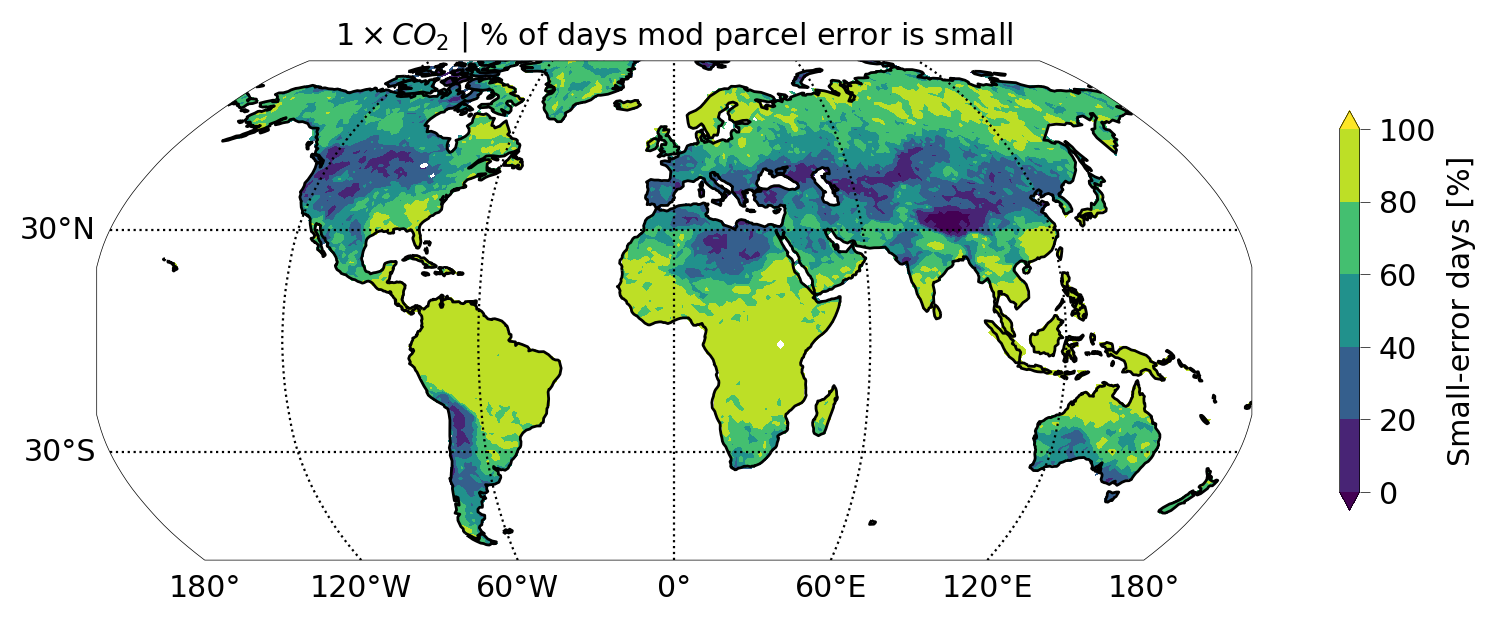

In [549]:
error_thresh = 0.25
error_thresh2 = 0.1
const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
mod_parcel1_error = np.abs(ds.mod_parcel1_error.sum(dim='layer') / ds.mod_parcel1_integral.sum(dim='layer'))
mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh)

fig = plt.figure(constrained_layout=True, figsize=(10., 3))
ax = fig.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
ax = [ax]

var = (100 * mask_fit.sum(dim='sample') / ds.sample.size).where(lsm)
initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max, bottom_labels=True, fontsize=10.84)
im = plot_contour_projection(ax[0], var.isel(co2=0), levels=np.arange(0, 120, 20))
plt.colorbar(im, ax=ax[0], label='Small-error days [%]', shrink=0.8)
ax[0].set_title(f"${int(ds.co2[0])} \\times CO_2$ | % of days mod parcel error is small")

# initialize_ax_projection(ax[1], lat_min=lat_min, lat_max=lat_max, fontsize=10.84)
# im = plot_contour_projection(ax[1], var.isel(co2=1) - var.isel(co2=0), cmap='coolwarm', levels=np.arange(-40, 60, 20))
# plt.colorbar(im, ax=ax[1], label='Small-error days change [%]', shrink=0.8)
# ax[1].set_title(f"(${int(ds.co2[1])} \\times CO_2$) - (${int(ds.co2[0])} \\times CO_2$)")

fontsize_use = update_fontsize(fig, 5)
plt.show()
isca_tools.savefig(fig)

In [216]:
error_use = 100 * ds.isel(co2=0, sample=0).mod_parcel1_error.sum(dim='layer') / ds.isel(co2=0,
                                                                                        sample=0).mod_parcel1_integral.sum(
    dim='layer')
error_use2 = 100 * ds.isel(co2=0, sample=0).const1_error.sum(dim='layer') / ds.isel(co2=0,
                                                                                    sample=0).const1_integral.sum(
    dim='layer')
error_use = np.abs(error_use)
error_use2 = np.abs(error_use2)
# error_use.lon.where(lsm & (error_use > 25) & (error_use2 < 12)).sel(lat=60, method='nearest')

## Example Days
#### Aquaplanet
Below I show example days to indicate why simple CAPE increases so much for the coldest days.
This also introduces `mod_parcel` framework, and shows two days where it is better than `const_lapse`.

#### Land
This is to show an example day which is undergoing shallow convection, and `const_lapse` is better than `mod_parcel`, so non-convective day.

Kappa = 1.0 | Lat = 18.1 | x=1
Convflag: 2.0
Epsilon: -7299 J/kg
sCAPE: -426 J/kg
Kappa = 1.5 | Lat = 18.1 | x=1
Convflag: 2.0
Epsilon: -1054 J/kg
sCAPE: -46 J/kg


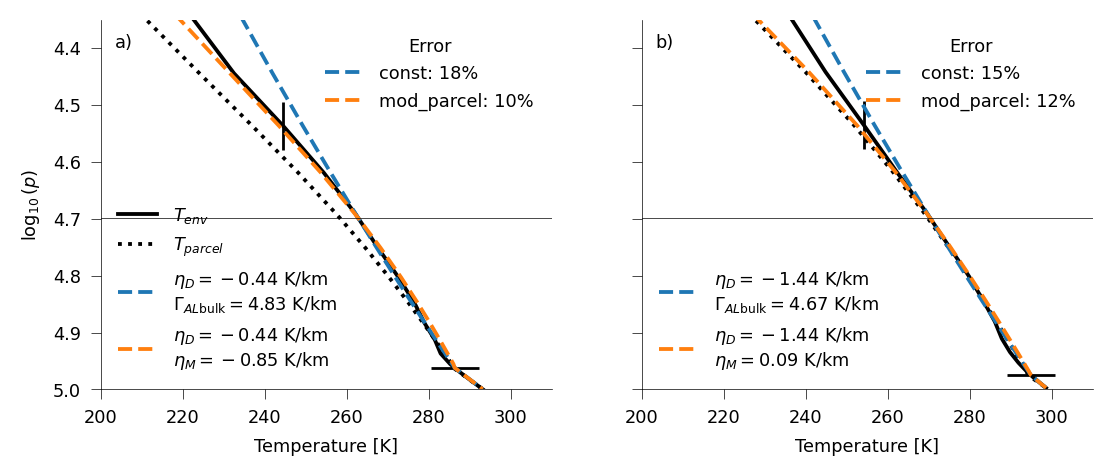

In [217]:
lat_plot = 18
surf_plot = 'aquaplanet'
sample_plot_ind = {'aquaplanet': [79, 64], 'land': [6, 21]}         # Good examples with convflag = 2 and lower mod_parcel error
# sample_plot_ind = [6, 21]          # Good examples with convflag = 2 and lower mod_parcel error
quant_plot = 0
show_lcl_markers = True

fig, ax = plt.subplots(1, n_exp, sharey=True, sharex=True)
fig_resize(fig, width['one_col']*2)
for j in range(n_exp):
    ds_plot = ds[surf_plot].sel(lat=lat_plot, method='nearest').isel(tau_lw=j).sel(quant=quant_plot, method='nearest')
    # ds_plot = ds_plot.mean(dim='sample')
    # ds_plot.attrs = ds['land'].attrs
    # print(np.where((ds_plot.convflag>=2) & (ds_plot.mod_parcel1_error.sum(dim='layer') < ds_plot.const1_error.sum(dim='layer')))[0][[1, 6][j]])   # how I got sample inds for aquaplanet
    # print(np.where((ds_plot.convflag<=1) & (ds_plot.mod_parcel1_error.sum(dim='layer') > ds_plot.const1_error.sum(dim='layer')) &
    #                (np.abs(ds_plot.mod_parcel1_error.sum(dim='layer')/ds_plot.mod_parcel1_integral.sum(dim='layer'))>0.25))[0])   # how I got sample inds for land
    ds_plot = ds_plot.isel(sample=sample_plot_ind[surf_plot][j])

    ds_plot['lnb_ind'] = get_lnb_lev_ind(ds_plot.T, ds_plot.Z3, get_P(ds_plot))
    p_thresh = float(get_P(ds_plot).isel(lev=ds_plot.lnb_ind) - 1)
    p_thresh = 0

    ds_plot['p_lcl'] = lcl_sigma_bolton_simple(ds_plot.rh_REFHT, ds_plot.temp_surf_lcl_calc) * ds_plot.PREFHT
    ds_plot['T_lcl_env'] = get_var_at_plev(ds_plot.T, get_P(ds_plot), ds_plot.p_lcl)

    p_use, temp_env_use = insert_to_array(get_P(ds_plot).to_numpy(), ds_plot.T.to_numpy(),
                                          [float(ds_plot.p_lcl), ds_plot.p_ft],
                                          [float(ds_plot.T_lcl_env), float(ds_plot.T_ft_env)])
    use_lev = p_use >= p_thresh
    ax[j].plot(temp_env_use[use_lev], np.log10(p_use)[use_lev], color='k', label='$T_{env}$' if j == 0 else None)

    T_parcel_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                           float(ds_plot.rh_REFHT),
                                           lapse_dry, 0,
                                           method_layer2='mod_parcel')
    ax[j].plot(T_parcel_use[use_lev], np.log10(p_use)[use_lev], color='k', linestyle=':',
               label='$T_{parcel}$' if j == 0 else None)

    line_leg2 = []
    line_leg2_label = []
    for i, key in enumerate(['const1', 'mod_parcel1']):
        temp_approx_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                                  float(ds_plot[f"rh_REFHT"]),
                                                  float(ds_plot[f"{key}_lapse"].isel(layer=0)) / 1000,
                                                  float(ds_plot[f"{key}_lapse"].isel(layer=1)) / 1000,
                                                  method_layer2=key.replace('1', ''))
        label_m = '$\eta_M' if i == 1 else '$\Gamma_{AL\mathrm{bulk}}'
        label_use = (f"$\eta_{'{D}'} = {ds_plot[f'{key}_lapse'].isel(layer=0) - lapse_dry * 1000:.2f}$ K/km\n"
                     f"{label_m} = {ds_plot[f'{key}_lapse'].isel(layer=1):.2f}$ K/km")
        line, = ax[j].plot(temp_approx_use[use_lev], np.log10(p_use)[use_lev], color=f'C{i}',
                           label=label_use, linestyle='--')
        line_leg2.append(line)
        label_use = f'{key[:-1]}: {np.abs(np.sum(ds_plot[f"{key}_error"]) / np.sum(ds_plot[f"{key}_integral"]) * 100):.0f}%'
        line_leg2_label.append(label_use)

    if show_lcl_markers:
        ax[j].scatter(ds_plot.T_lcl_env, np.log10(ds_plot.p_lcl), marker='_', s=300, color='k', lw=1)
        p_integ_upper_ind = np.where(p_use < float(ds_plot.p_ft))[0][-ds_plot.n_lev_above_integral]
        ax[j].scatter(ds_plot.T[p_integ_upper_ind], np.log10(p_use[p_integ_upper_ind]), color='k', marker='|', s=300, lw=1)
    update_linewidth(fig, 1.5)
    # Legend 2 (e.g., model meaning)
    leg2 = ax[j].legend(
        handles=line_leg2,
        labels=line_leg2_label,
        loc="upper right",
        title="Error"
    )
    ax[j].add_artist(leg2)
    ax[j].legend(loc='lower left')
    # ax[j].set_title(
    #     f"$\kappa={ds_plot.tau_lw:.1f}$ | Lat = {ds_plot.lat:.1f}$\degree$ | $x={ds_plot.quant:.0f}$",
    #     fontsize=8.5)

    # Print out useful info
    print(f"Kappa = {ds_plot.tau_lw:.1f} | Lat = {ds_plot.lat:.1f} | x={ds_plot.quant:.0f}")
    print(f"Convflag: {ds_plot.convflag.values:.1f}")
    print(f"Epsilon: {(ds_plot.mse_REFHT - ds_plot.mse_ft_sat_env).values*1000:.0f} J/kg")
    ds_plot['sCAPE'] = get_cape_approx(float(ds_plot.TREFHT), float(ds_plot.rh_REFHT), float(ds_plot.PREFHT), float(ds_plot.p_ft),
                                       float(ds_plot.T_ft_env),
                                       float(ds_plot.mse_REFHT - ds_plot.mse_ft_sat_env))[0]
    print(f"sCAPE: {float(ds_plot.sCAPE)*1000:.0f} J/kg")

ax[0].invert_yaxis()

ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('Temperature [K]')
#
ax[0].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
p_integ_upper_ind = np.where(p_use < float(ds_plot.p_ft))[0][-ds_plot.n_lev_above_integral]
ax[1].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)

#
# # update_linewidth(fig)

ax[0].set_ylim(5, 4.35)
ax[0].set_xlim(200, 310)
label_subplots(fig, ax)
update_fontsize(fig, 7)
plt.show()
# isca_tools.savefig(fig)

## Example Days - Land
This is to show an example day which is undergoing shallow convection, and `const_lapse` is better than `mod_parcel`, so non-convective day.

In [173]:
ds_plot = ds['land'].sel(lat=lat_plot, method='nearest').isel(tau_lw=j).sel(quant=quant_plot, method='nearest')

Kappa = 1.0 | Lat = 18.1 | x=1
Convflag: 1.0
Epsilon: -2683 J/kg
sCAPE: -154 J/kg
Kappa = 1.5 | Lat = 18.1 | x=1
Convflag: 0.5
Epsilon: 1438 J/kg
sCAPE: 71 J/kg


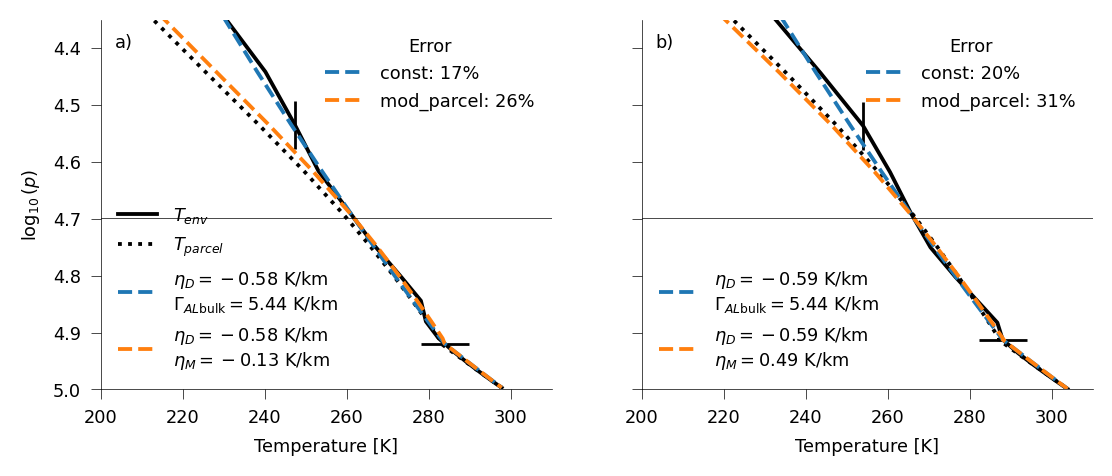

In [215]:
lat_plot = 18
sample_plot_ind = [6, 21]          # Good examples with convflag = 2 and lower mod_parcel error
quant_plot = 0
show_lcl_markers = True

fig, ax = plt.subplots(1, n_exp, sharey=True, sharex=True)
fig_resize(fig, width['one_col']*2)
for j in range(n_exp):
    ds_plot = ds['land'].sel(lat=lat_plot, method='nearest').isel(tau_lw=j).sel(quant=quant_plot, method='nearest')
    # ds_plot = ds_plot.mean(dim='sample')
    # ds_plot.attrs = ds['land'].attrs

    ds_plot = ds_plot.isel(sample=sample_plot_ind[j])

    ds_plot['lnb_ind'] = get_lnb_lev_ind(ds_plot.T, ds_plot.Z3, get_P(ds_plot))
    p_thresh = float(get_P(ds_plot).isel(lev=ds_plot.lnb_ind) - 1)
    p_thresh = 0

    ds_plot['p_lcl'] = lcl_sigma_bolton_simple(ds_plot.rh_REFHT, ds_plot.temp_surf_lcl_calc) * ds_plot.PREFHT
    ds_plot['T_lcl_env'] = get_var_at_plev(ds_plot.T, get_P(ds_plot), ds_plot.p_lcl)

    p_use, temp_env_use = insert_to_array(get_P(ds_plot).to_numpy(), ds_plot.T.to_numpy(),
                                          [float(ds_plot.p_lcl), ds_plot.p_ft],
                                          [float(ds_plot.T_lcl_env), float(ds_plot.T_ft_env)])
    use_lev = p_use >= p_thresh
    ax[j].plot(temp_env_use[use_lev], np.log10(p_use)[use_lev], color='k', label='$T_{env}$' if j == 0 else None)

    T_parcel_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                           float(ds_plot.rh_REFHT),
                                           lapse_dry, 0,
                                           method_layer2='mod_parcel')
    ax[j].plot(T_parcel_use[use_lev], np.log10(p_use)[use_lev], color='k', linestyle=':',
               label='$T_{parcel}$' if j == 0 else None)

    line_leg2 = []
    line_leg2_label = []
    for i, key in enumerate(['const1', 'mod_parcel1']):
        temp_approx_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                                  float(ds_plot[f"rh_REFHT"]),
                                                  float(ds_plot[f"{key}_lapse"].isel(layer=0)) / 1000,
                                                  float(ds_plot[f"{key}_lapse"].isel(layer=1)) / 1000,
                                                  method_layer2=key.replace('1', ''))
        label_m = '$\eta_M' if i == 1 else '$\Gamma_{AL\mathrm{bulk}}'
        label_use = (f"$\eta_{'{D}'} = {ds_plot[f'{key}_lapse'].isel(layer=0) - lapse_dry * 1000:.2f}$ K/km\n"
                     f"{label_m} = {ds_plot[f'{key}_lapse'].isel(layer=1):.2f}$ K/km")
        line, = ax[j].plot(temp_approx_use[use_lev], np.log10(p_use)[use_lev], color=f'C{i}',
                           label=label_use, linestyle='--')
        line_leg2.append(line)
        label_use = f'{key[:-1]}: {np.abs(np.sum(ds_plot[f"{key}_error"]) / np.sum(ds_plot[f"{key}_integral"]) * 100):.0f}%'
        line_leg2_label.append(label_use)

    if show_lcl_markers:
        ax[j].scatter(ds_plot.T_lcl_env, np.log10(ds_plot.p_lcl), marker='_', s=300, color='k', lw=1)
        p_integ_upper_ind = np.where(p_use < float(ds_plot.p_ft))[0][-ds_plot.n_lev_above_integral]
        ax[j].scatter(ds_plot.T[p_integ_upper_ind], np.log10(p_use[p_integ_upper_ind]), color='k', marker='|', s=300, lw=1)
    update_linewidth(fig, 1.5)
    # Legend 2 (e.g., model meaning)
    leg2 = ax[j].legend(
        handles=line_leg2,
        labels=line_leg2_label,
        loc="upper right",
        title="Error"
    )
    ax[j].add_artist(leg2)
    ax[j].legend(loc='lower left')
    # ax[j].set_title(
    #     f"$\kappa={ds_plot.tau_lw:.1f}$ | Lat = {ds_plot.lat:.1f}$\degree$ | $x={ds_plot.quant:.0f}$",
    #     fontsize=8.5)

    # Print out useful info
    print(f"Kappa = {ds_plot.tau_lw:.1f} | Lat = {ds_plot.lat:.1f} | x={ds_plot.quant:.0f}")
    print(f"Convflag: {ds_plot.convflag.values:.1f}")
    print(f"Epsilon: {(ds_plot.mse_REFHT - ds_plot.mse_ft_sat_env).values*1000:.0f} J/kg")
    ds_plot['sCAPE'] = get_cape_approx(float(ds_plot.TREFHT), float(ds_plot.rh_REFHT), float(ds_plot.PREFHT), float(ds_plot.p_ft),
                                       float(ds_plot.T_ft_env),
                                       float(ds_plot.mse_REFHT - ds_plot.mse_ft_sat_env))[0]
    print(f"sCAPE: {float(ds_plot.sCAPE)*1000:.0f} J/kg")

ax[0].invert_yaxis()

ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('Temperature [K]')
#
ax[0].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
p_integ_upper_ind = np.where(p_use < float(ds_plot.p_ft))[0][-ds_plot.n_lev_above_integral]
ax[1].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)

#
# # update_linewidth(fig)

ax[0].set_ylim(5, 4.35)
ax[0].set_xlim(200, 310)
label_subplots(fig, ax)
update_fontsize(fig, 7)
plt.show()
# isca_tools.savefig(fig)